### Stage 1: Data Preparation

- [ ] Download [OpenEarthMap](https://zenodo.org/records/7223446) dataset using `zenodo-get` command
- [ ] Organise Metadata for OpenEarthMap dataset
- [ ] Create training, test, and validation splits
- [ ] Export Metadata as a CSV file

In [1]:
from pathlib import Path
from src.utils.common import read_yaml, show_config
from src import PARAMS_FILEPATH
from typing import List
from dataclasses import dataclass

@dataclass(frozen=True)
class DataConfig: 
    doi: str
    out_dir: Path
    train_test_val_split: List
    metadata_file: Path
    random_seed: int

class ConfigManager:
    def __init__(self, config_path = PARAMS_FILEPATH) -> None:
        self.config = read_yaml(config_path)

    def get_data_config(self) -> DataConfig:
        Path(self.config["out_dir"]).mkdir(parents=True, exist_ok=True)
        cfg = DataConfig(
            doi = self.config["doi"],
            out_dir = Path(self.config["out_dir"]),
            train_test_val_split = self.config["train_test_val_split"],
            metadata_file = Path(self.config["metadata_file"]),
            random_seed = self.config["random_seed"]
        )
        return cfg

cfg = ConfigManager().get_data_config()
show_config(cfg)

doi: 10.5281/zenodo.7223446
out_dir: data
train_test_val_split: [0.75, 0.15, 0.1]
metadata_file: data/metadata.csv
random_seed: 37


In [6]:
# Components
import os
import subprocess

class DataComponents:
    def __init__(self, cfg: DataConfig) -> None:
        self.config = cfg
    
    def download_data(self, unzip: bool = True, remove_zip: bool = False) -> None:
        print(f">>>>>>>>>>>> Downloading data from Zenodo <<<<<<<<<<<<")
        if not Path(self.config.out_dir).joinpath("OpenEarthMap_wo_xBD").exists() and not Path(self.config.out_dir).joinpath("OpenEarthMap.zip").exists():
            cmd = f"zenodo_get -e -d {self.config.doi} -o {self.config.out_dir}"
            subprocess.run(cmd, shell=True)
            if unzip:
                print(f"--> Unzipping data")
                cmd = f"unzip -q {self.config.out_dir}/OpenEarthMap.zip -d {self.config.out_dir}"
                subprocess.run(cmd, shell=True)
                if remove_zip:
                    os.remove(f"{self.config.out_dir}/OpenEarthMap.zip")
        else:
            print("--> Data already downloaded. Skipping.")
            
    def aggregate_data(self) -> None:
        from pathlib import Path
        print(f">>>>>>>>>>>> Aggregating data <<<<<<<<<<<<")
        # Aggregate Metadata
        imgs = sorted(list(Path(self.config.out_dir).joinpath("OpenEarthMap_wo_xBD").rglob('*/images/*.tif')))
        labels = sorted(list(Path(self.config.out_dir).joinpath("OpenEarthMap_wo_xBD").rglob('*/labels/*.tif')))

        self.images = []
        self.masks = []
        # Check if labels exist
        for img in imgs:
            for label in labels:
                if img.stem == label.stem:
                    self.images.append(img)
                    self.masks.append(label)
                    
        print(f"--> Number of images with labels: {len(self.images)}")
        
        # Delete images without labels
        for img in imgs:
            if img not in self.images:
                os.remove(img)
        for label in labels:
            if label not in self.masks:
                os.remove(label)
    
    def split_data(self) -> None:
        import pandas as pd
        print(f">>>>>>>>>>>> Splitting data into train/val/test sets <<<<<<<<<<<<")  
        from sklearn.model_selection import train_test_split

        meta = pd.DataFrame({"image": self.images, "mask": self.masks})

        # Assuming cfg.train_test_val_split is a list of three values summing to 1, e.g. [0.7, 0.2, 0.1]
        train_ratio, val_ratio, test_ratio = self.config.train_test_val_split

        # First split: separate train from the rest
        train_df, temp_df = train_test_split(meta, train_size=train_ratio, random_state=self.config.random_seed)

        # Second split: divide the rest into val and test
        val_ratio_adjusted = val_ratio / (val_ratio + test_ratio)
        val_df, test_df = train_test_split(temp_df, train_size=val_ratio_adjusted, random_state=self.config.random_seed)

        # Assign groups
        train_df["group"] = "train"
        val_df["group"] = "val"
        test_df["group"] = "test"
        
        print(f"--> Number of images in train/val/test sets: {len(train_df)}, {len(val_df)}, {len(test_df)}")

        # Combine
        self.metadata = pd.concat([train_df, val_df, test_df], axis=0)

        # Save
        self.metadata.to_csv(self.config.metadata_file, index=False)
        print(f"Metadata saved to {self.config.metadata_file}")

In [7]:
pipeline = DataComponents(ConfigManager().get_data_config())
pipeline.download_data(unzip=True, remove_zip=False)
pipeline.aggregate_data()
pipeline.split_data()

>>>>>>>>>>>> Downloading data from Zenodo <<<<<<<<<<<<
----------- Data already downloaded -----------
>>>>>>>>>>>> Aggregating data <<<<<<<<<<<<
Number of images with labels: 2687
>>>>>>>>>>>> Splitting data into train/val/test sets <<<<<<<<<<<<
Number of images in train/val/test sets: 2015, 403, 269
Metadata saved to data/metadata.csv


### Stage 2: Training and Evaluation

- [ ] Create DataLoader
- [ ] Initialise Model
- [ ] Train Model
- [ ] Evaluate Model

In [1]:
from dataclasses import dataclass
from src import PARAMS_FILEPATH
from pathlib import Path

@dataclass(frozen=True)
class Config:
    metadata_csv: Path
    models_dir: Path
    logs_dir: Path
    architecture: str
    encoder: str
    encoder_weights: str
    n_classes: int
    n_channels: int
    epochs: int
    lr: float
    batch_size: int
    device: str
    num_workers: int
    resize_dimension: int
    apply_preprocessing: bool
    dev_run: bool
    tune_lr: bool
    checkpoint_path: Path
    encoder: str
    optimizer: str
    loss: str
    
from src.utils.common import read_yaml, show_config

class ConfigManager:
    def __init__(self, params_filepath: Path = PARAMS_FILEPATH) -> None:
        self.config = read_yaml(params_filepath)
        if not Path(self.config.models_dir).exists(): Path(self.config.models_dir).mkdir(parents=True, exist_ok=True)
        if not Path(self.config.logs_dir).exists(): Path(self.config.logs_dir).mkdir(parents=True, exist_ok=True)
        
    def get_config(self) -> Config:
        params = self.config
        cfg = Config(
            models_dir=Path(params.models_dir),
            metadata_csv=Path(params.metadata_file),
            logs_dir=Path(params.logs_dir),
            architecture=params.architecture,
            encoder=params.encoder,
            encoder_weights=params.encoder_weights,
            n_classes=params.n_classes,
            n_channels=params.n_channels,
            epochs=params.epochs,
            lr=params.lr,
            batch_size=params.batch_size,
            device=params.device,
            num_workers=params.num_workers,
            resize_dimension=params.resize_dimension,
            dev_run=params.dev_run,
            tune_lr=params.tune_lr,
            apply_preprocessing=params.apply_preprocessing,
            checkpoint_path=None if params.checkpoint_path == 'None' else Path(params.checkpoint_path),
            optimizer=params.optimizer,
            loss=params.loss
        )
        return cfg
        
cfg = ConfigManager().get_config()
show_config(cfg)

metadata_csv: metadata.csv
models_dir: models
logs_dir: logs
architecture: DeepLabV3Plus
encoder: efficientnet-b0
encoder_weights: imagenet
n_classes: 9
n_channels: 3
epochs: 15
lr: 0.04
batch_size: 16
device: auto
num_workers: 24
resize_dimension: 512
apply_preprocessing: False
dev_run: False
tune_lr: False
checkpoint_path: None
optimizer: adamax
loss: DiceLoss


In [2]:
# Components
from src.utils.dataloader import OEMDataModule, get_training_augmentation, get_preprocessing, get_preprocessing_function
from src.utils.model import SegmentationModel
import pytorch_lightning as pl
import torch
import os
import warnings; warnings.filterwarnings("ignore")
torch.set_float32_matmul_precision('medium')

class Components:
    def __init__(self, config: Config) -> None:
        self.config = config
        
    def create_dataloaders(self):
        print(f'------------- Creating Dataloaders -------------')
        if self.config.apply_preprocessing:
            print('------------->>> Applying Preprocessing <<<-------------')
            self.dm = OEMDataModule(
                metadata_csv=self.config.metadata_csv,
                # augmentation=None,
                augmentation=get_training_augmentation(),
                preprocessing=get_preprocessing(get_preprocessing_function(self.config.encoder, self.config.encoder_weights)),
                batch_size=self.config.batch_size,
                num_workers=self.config.num_workers,
                resize_dimensions=self.config.resize_dimension
            )
        else:
            print('------------->>> Skipping: Applying Preprocessing <<<-------------')
            self.dm = OEMDataModule(
                metadata_csv=self.config.metadata_csv,
                # augmentation=None, 
                augmentation=get_training_augmentation(),
                preprocessing=None,
                batch_size=self.config.batch_size,
                num_workers=self.config.num_workers,
                resize_dimensions=self.config.resize_dimension
            )
    
    def initialise_model(self):
        print(f'------------- Inistialising Model: Architecture: {self.config.architecture} | Encoder: {self.config.encoder} | Encoder Weights: {self.config.encoder_weights} -------------')
        self.model = SegmentationModel(
            architecture=self.config.architecture,
            n_channels=self.config.n_channels,
            n_classes=self.config.n_classes,
            lr=self.config.lr,
            encoder=self.config.encoder,
            encoder_weights=self.config.encoder_weights,
            loss=self.config.loss,
            optimizer=self.config.optimizer,
        )
    
    def load_checkpoint(self):
        if self.config.checkpoint_path is not None and os.path.exists(self.config.checkpoint_path):
            print('------------- Loading Checkpoint -------------')
            print(f'Loading checkpoint from {self.config.checkpoint_path}')
            try:
                self.model = SegmentationModel.load_from_checkpoint(self.config.checkpoint_path, hparams_file='params.yaml')
                print('Checkpoint loaded successfully')
            except Exception as e:
                print(f'Failed to load checkpoint: {e}')

    
    def create_callbacks(self):
        print('------------- Creating Callbacks -------------')
        ### Define Checkpoints for Early Stopping, Tensorboard Summary Writer, and Best Checkpoint Saving
        from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
        from pytorch_lightning.loggers import TensorBoardLogger

        # Early stopping callback
        self.early_stopping = EarlyStopping(
            monitor='val_loss',  # Metric to monitor
            patience=10,          # Number of epochs with no improvement after which training will be stopped
            verbose=True,
            mode='min'           # Mode can be 'min' for minimizing the monitored metric or 'max' for maximizing it
        )

        # Model checkpoint callback
        self.checkpoint_callback = ModelCheckpoint(
            monitor='val_f1',   # Metric to monitor
            filename='{epoch:02d}-{val_f1:.2f}',  # Filename format
            save_top_k=1,         # Save the top k models
            mode='max',           # Mode can be 'min' or 'max'
            verbose=True,
            dirpath=self.config.logs_dir.joinpath(f'{self.config.architecture}_{self.config.encoder}/checkpoints')
        )

        # TensorBoard logger
        self.tensorboard_logger = TensorBoardLogger(
            save_dir=self.config.logs_dir,     # Directory to save the logs
            name=f"{self.config.architecture}_{self.config.encoder}"       # Experiment name
        )

        from pytorch_lightning.callbacks import LearningRateMonitor
        # Learning rate monitor
        self.lr_monitor = LearningRateMonitor(logging_interval='epoch')
        
    def tune_lr(self):
        if self.config.tune_lr:
            from pytorch_lightning.tuner.tuning import Tuner
            print('------------- Tunning Learning Rate -------------')
            # Define a separate trainer for hyperparameter tuning
            self.tuning_trainer = pl.Trainer(
                accelerator=self.config.device,
                precision="16-mixed",
                logger=self.tensorboard_logger,
                callbacks=None,
                max_epochs=5  # Set this to a low number for faster tuning
            )

            self.dm.setup('fit')

            # Hyperparameter tuning
            self.tuner = Tuner(self.tuning_trainer)
            self.new_lr = self.tuner.lr_find(self.model, train_dataloaders=self.dm.train_dataloader(), val_dataloaders=self.dm.val_dataloader()).suggestion()
            print(f'Suggested learning rate: {self.new_lr}')
        else:
            print('------------- Skipping Tunning Learning Rate -------------')
        
    def create_trainer(self):
        print(f'------------- Training Model: {self.config.architecture} with {self.config.encoder} Encoder -------------')
        self.trainer = pl.Trainer(
            accelerator=self.config.device,
            max_epochs=self.config.epochs,
            precision="16-mixed",
            logger= self.tensorboard_logger if hasattr(self, 'tensorboard_logger') else None,
            callbacks=[self.early_stopping, self.checkpoint_callback, self.lr_monitor],
            enable_progress_bar=True,
            fast_dev_run=self.config.dev_run,
        )
    
    def train(self):
        print('------------- Training Started -------------')
        self.dm.setup('fit')
        if self.config.checkpoint_path is not None and os.path.exists(self.config.checkpoint_path):
            print(f'Resuming training from checkpoint: {self.config.checkpoint_path}')
            self.trainer.fit(model=self.model, train_dataloaders=self.dm.train_dataloader(), val_dataloaders=self.dm.val_dataloader(), ckpt_path=self.config.checkpoint_path)
        else:
            self.trainer.fit(model=self.model, train_dataloaders=self.dm.train_dataloader(), val_dataloaders=self.dm.val_dataloader())
        print('------------- Training Completed -------------')            

In [3]:
pipeline = Components(config=ConfigManager().get_config())
pipeline.create_dataloaders()

------------- Creating Dataloaders -------------
------------->>> Skipping: Applying Preprocessing <<<-------------


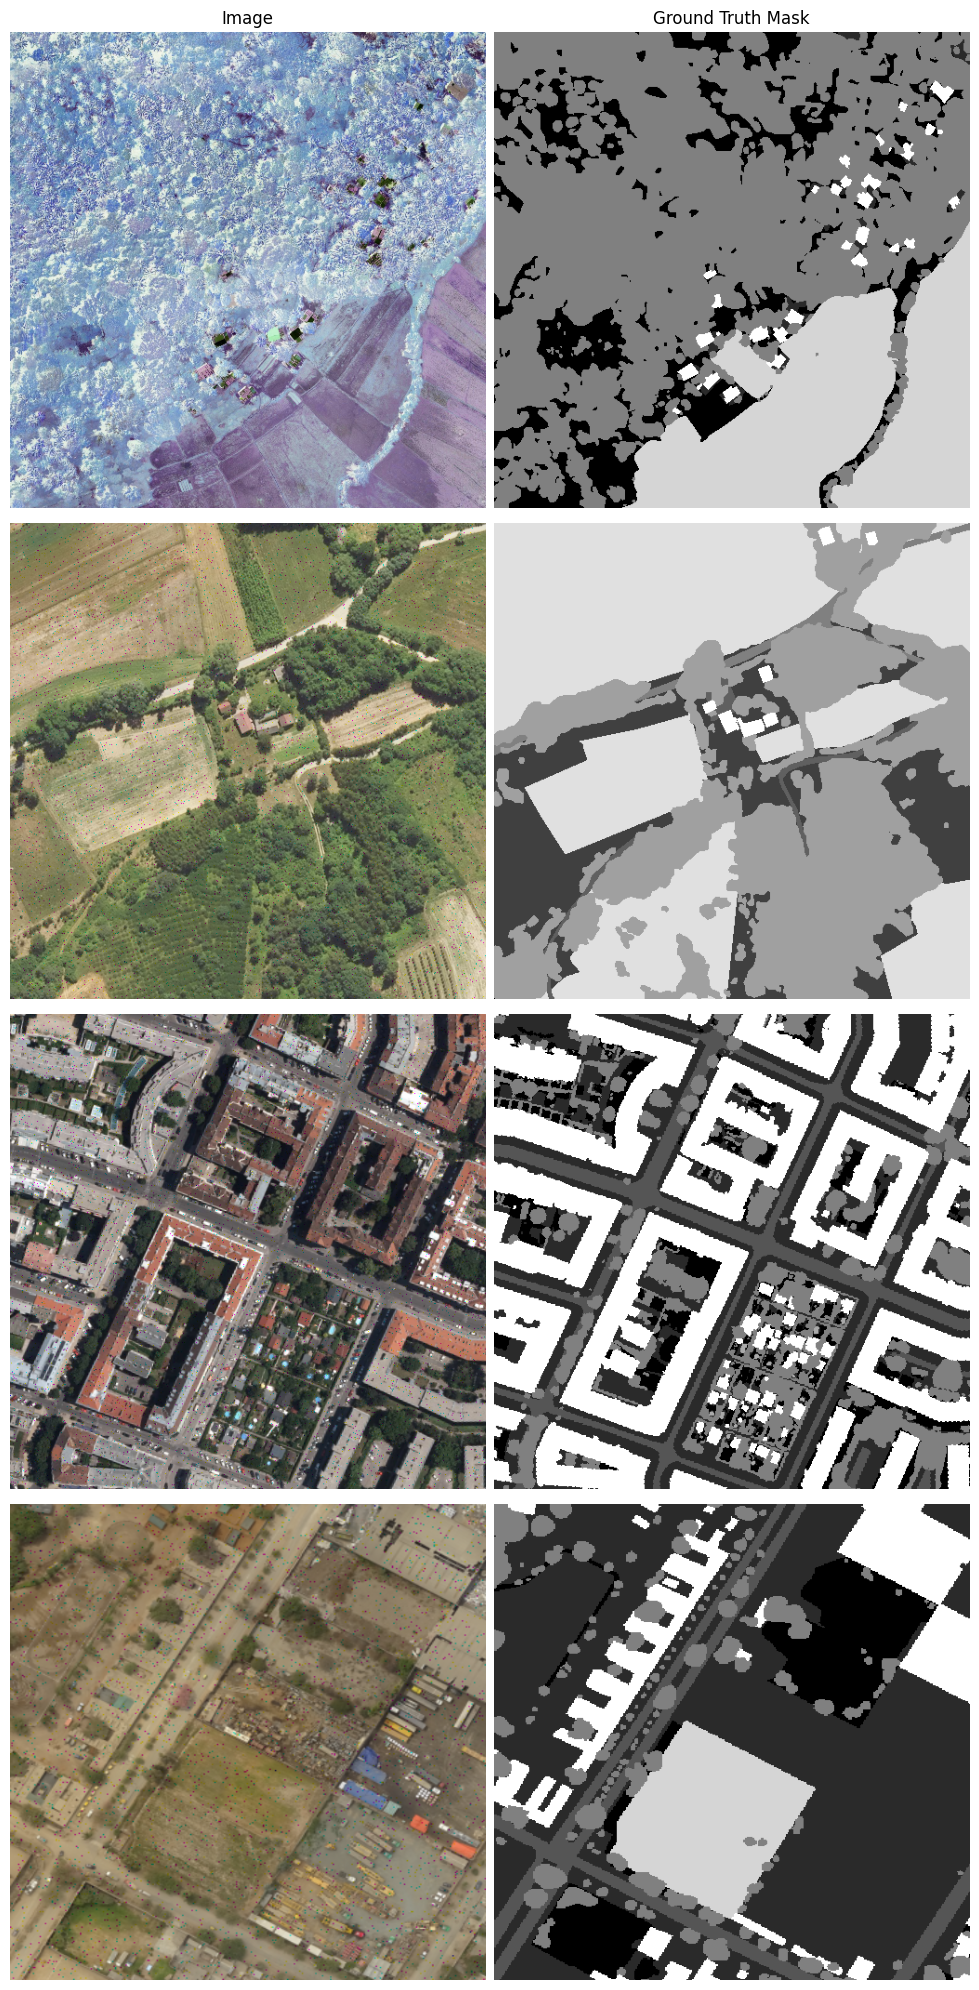

In [4]:
from src.utils.plotting import plot_train_batch
plot_train_batch(dm=pipeline.dm, randomised=False)

In [5]:
pipeline.initialise_model()
pipeline.load_checkpoint()
pipeline.create_callbacks()
pipeline.tune_lr()
pipeline.create_trainer()
pipeline.train()

------------- Inistialising Model: Architecture: DeepLabV3Plus | Encoder: efficientnet-b0 | Encoder Weights: imagenet -------------
------------- Creating Callbacks -------------
------------- Skipping Tunning Learning Rate -------------
------------- Training Model: DeepLabV3Plus with efficientnet-b0 Encoder -------------


INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


------------- Training Started -------------


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type          | Params | Mode 
--------------------------------------------------
0 | model   | DeepLabV3Plus | 4.9 M  | train
1 | loss_fn | DiceLoss      | 0      | train
--------------------------------------------------
4.9 M     Trainable params
0         Non-trainable params
4.9 M     Total params
19.638    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 0.921
INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 125: 'val_f1' reached 0.20341 (best 0.20341), saving model to '/mnt/e/Research/dvc/OpenEarthMap/logs/DeepLabV3Plus_efficientnet-b0/checkpoints/epoch=00-val_f1=0.20.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.082 >= min_delta = 0.0. New best score: 0.839
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 250: 'val_f1' reached 0.31652 (best 0.31652), saving model to '/mnt/e/Research/dvc/OpenEarthMap/logs/DeepLabV3Plus_efficientnet-b0/checkpoints/epoch=01-val_f1=0.32.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.166 >= min_delta = 0.0. New best score: 0.672
INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 375: 'val_f1' reached 0.44580 (best 0.44580), saving model to '/mnt/e/Research/dvc/OpenEarthMap/logs/DeepLabV3Plus_efficientnet-b0/checkpoints/epoch=02-val_f1=0.45.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.671
INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 500: 'val_f1' reached 0.45208 (best 0.45208), saving model to '/mnt/e/Research/dvc/OpenEarthMap/logs/DeepLabV3Plus_efficientnet-b0/checkpoints/epoch=03-val_f1=0.45.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.070 >= min_delta = 0.0. New best score: 0.600
INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 625: 'val_f1' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.590
INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 750: 'val_f1' reached 0.45733 (best 0.45733), saving model to '/mnt/e/Research/dvc/OpenEarthMap/logs/DeepLabV3Plus_efficientnet-b0/checkpoints/epoch=05-val_f1=0.46.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.035 >= min_delta = 0.0. New best score: 0.554
INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 875: 'val_f1' reached 0.49640 (best 0.49640), saving model to '/mnt/e/Research/dvc/OpenEarthMap/logs/DeepLabV3Plus_efficientnet-b0/checkpoints/epoch=06-val_f1=0.50.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 7, global step 1000: 'val_f1' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.544
INFO:pytorch_lightning.utilities.rank_zero:Epoch 8, global step 1125: 'val_f1' reached 0.49650 (best 0.49650), saving model to '/mnt/e/Research/dvc/OpenEarthMap/logs/DeepLabV3Plus_efficientnet-b0/checkpoints/epoch=08-val_f1=0.50.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.540
INFO:pytorch_lightning.utilities.rank_zero:Epoch 9, global step 1250: 'val_f1' reached 0.52861 (best 0.52861), saving model to '/mnt/e/Research/dvc/OpenEarthMap/logs/DeepLabV3Plus_efficientnet-b0/checkpoints/epoch=09-val_f1=0.53.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 10, global step 1375: 'val_f1' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.532
INFO:pytorch_lightning.utilities.rank_zero:Epoch 11, global step 1500: 'val_f1' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 12, global step 1625: 'val_f1' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 13, global step 1750: 'val_f1' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 14, global step 1875: 'val_f1' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.


------------- Training Completed -------------


In [6]:
pipeline.dm.setup("test")
pipeline.trainer.test(dataloaders=pipeline.dm.test_dataloader())

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /mnt/e/Research/dvc/OpenEarthMap/logs/DeepLabV3Plus_efficientnet-b0/checkpoints/epoch=09-val_f1=0.53.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /mnt/e/Research/dvc/OpenEarthMap/logs/DeepLabV3Plus_efficientnet-b0/checkpoints/epoch=09-val_f1=0.53.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          test_f1          │     0.525077760219574     │
│          test_f2          │    0.5356267094612122     │
│         test_iou          │    0.4512701630592346     │
│         test_loss         │    0.5611014366149902     │
│      test_precision       │     0.659470796585083     │
│        test_recall        │    0.5976324677467346     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.5611014366149902,
  'test_iou': 0.4512701630592346,
  'test_f1': 0.525077760219574,
  'test_f2': 0.5356267094612122,
  'test_precision': 0.659470796585083,
  'test_recall': 0.5976324677467346}]

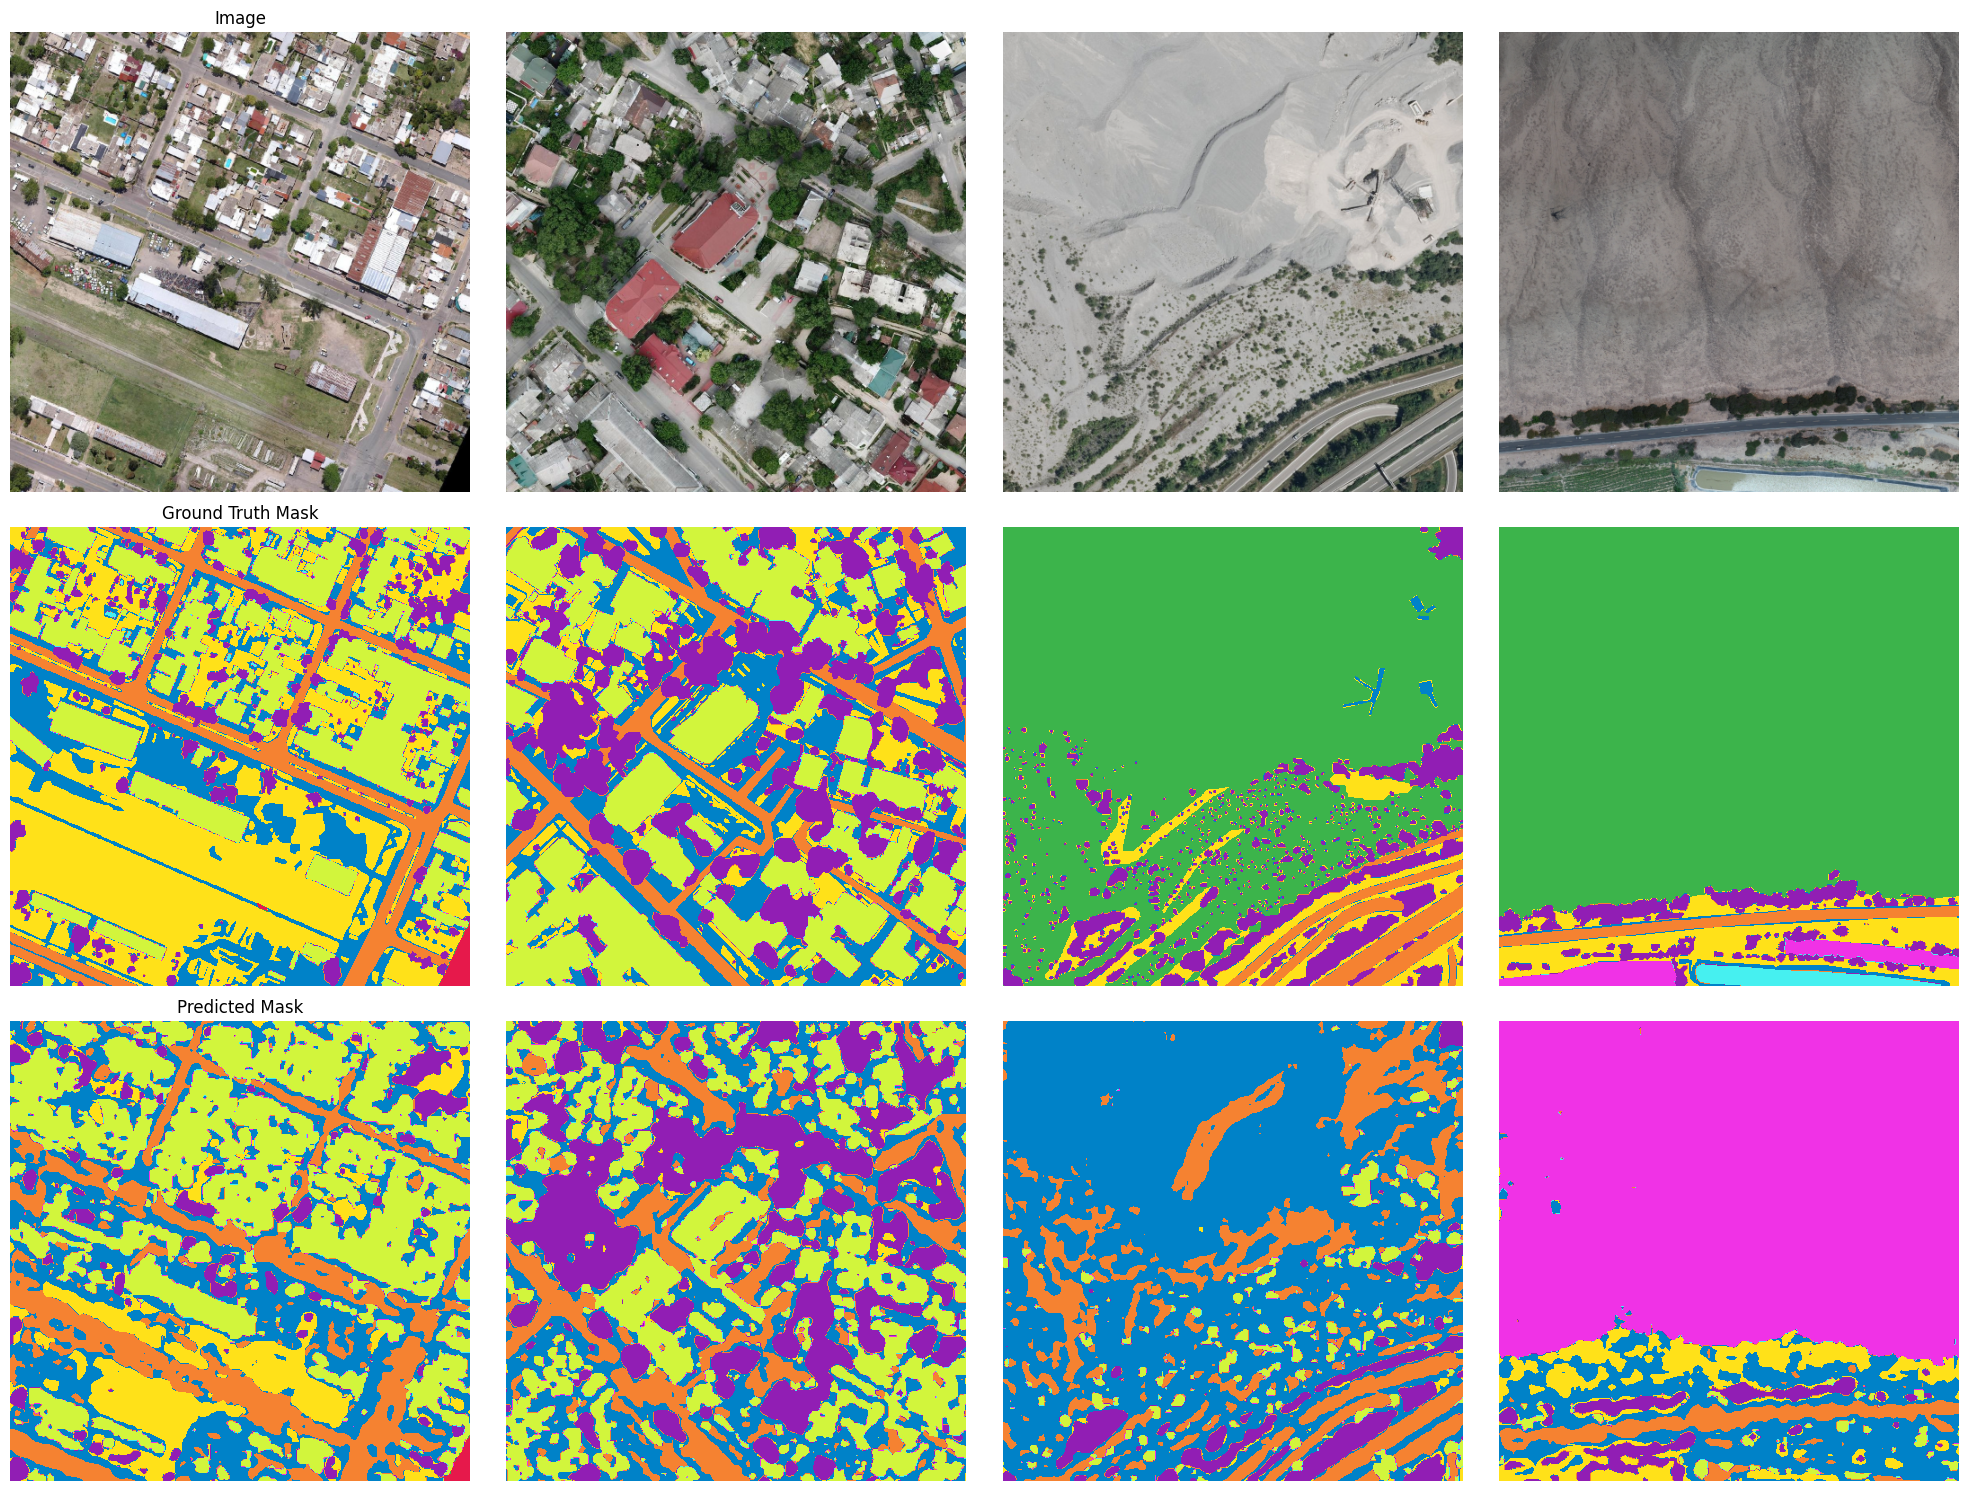

In [7]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import random
from matplotlib.colors import ListedColormap

# Define a discrete colormap with nine distinct colors
cmap = ListedColormap([
    '#e6194b', '#3cb44b', '#ffe119', '#0082c8',
    '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#d2f53c'
])

# Assuming the test dataloader and model setup as in the previous context
pipeline.dm.setup('test')

# Get the test dataloader
test_dataloader = pipeline.dm.test_dataloader()
test_dataloader_list = list(test_dataloader)

# Randomly select a batch of data
x, y = random.choice(test_dataloader_list)

# Put the model in evaluation mode
pipeline.model.eval()

# Disable gradients for this step
with torch.no_grad():
    # Pass the data through the model
    y_hat = pipeline.model(x)  # Ensure this is on the correct device if necessary

# Get the predicted mask by taking the argmax across the class dimension
predicted_mask = torch.argmax(y_hat, dim=1).cpu().numpy()

# Plot the results
fig, axs = plt.subplots(3, 4, figsize=(20, 15))  # 3 rows: image, ground truth, predicted mask
for i in range(4):
    # Plot the image
    image = np.transpose(x[i][:3, :, :], (1, 2, 0))
    axs[0, i].imshow(image)
    axs[0, i].axis('off')
    if i == 0:
        axs[0, i].set_title('Image')
    
    # Plot the ground truth mask
    ground_truth_mask = y[i][0].cpu().numpy()
    axs[1, i].imshow(ground_truth_mask, cmap=cmap, vmin=0, vmax=8)
    axs[1, i].axis('off')
    if i == 0:
        axs[1, i].set_title('Ground Truth Mask')

    # Plot the predicted mask
    axs[2, i].imshow(predicted_mask[i], cmap=cmap, vmin=0, vmax=8)
    axs[2, i].axis('off')
    if i == 0:
        axs[2, i].set_title('Predicted Mask')

plt.tight_layout()
plt.show()